In [1]:
cd drive/MyDrive/Colab\ Notebooks/NLP_twitter

/content/drive/MyDrive/Colab Notebooks/NLP_twitter


In [2]:
ls

data/                            sampling_model_no_feat_engineering.ipynb
model_no_feat_engineering.ipynb  spacy_models/


In [3]:
!pip install emot

     |████████████████████████████████| 61 kB 24 kB/s 


Install Polish SpaCy

In [4]:
!pip install -U pip setuptools wheel
!pip install -U 'spacy[cuda111]'
!python -m spacy download pl_core_news_sm

     |████████████████████████████████| 2.1 MB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 40.7 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.3/653.3 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.1/457.1 KB 17.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempt

In [5]:
!pip install imbalanced-learn

In [6]:
import re
import os
import string
from enum import Enum

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO

import spacy
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Balancing dataset
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1, l2, l1_l2


# Models
from sklearn.naive_bayes import BernoulliNB

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers.embeddings import Embedding

# Eval
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_score, RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

# Data Preprocessing

Filter duplicate values

Steps for data preprocessing:

1. Lowering the text
2. Removing `newline (\n)` characters
3. Removing URLs
4. Removing numbers
5.  

## Constants

According to the EDA, 60% of the training data occurred only once. Thus, `num_words=9000` for the Tokenizer should be enough

We can also use padding as the max length of a tweet is `280` characters

In [7]:
class Labels(Enum):
    NON_HARMFUL = 0
    HARMFUL = 1


NUM_WORDS = 3_000
MAX_TWEET_LENGTH = 280
OOV_TOKEN = '<OOV>'

## Loading data

In [8]:
DATA_DIR = 'data/'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train/')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test/')

MAX_TWEET_LENGTH = 280

In [9]:
!ls

data				 sampling_model_no_feat_engineering.ipynb
model_no_feat_engineering.ipynb  spacy_models


In [10]:
os.listdir(TRAIN_DATA_DIR)

['training_set_clean_only_text.txt', 'training_set_clean_only_tags.txt']

In [11]:
TRAIN_DATA = os.path.join(TRAIN_DATA_DIR, os.listdir(TRAIN_DATA_DIR)[0])
TRAIN_LABELS = os.path.join(TRAIN_DATA_DIR, os.listdir(TRAIN_DATA_DIR)[1])

In [12]:
data_df = pd.read_csv(TRAIN_DATA, sep='\n', names=['text'])
labels_df = pd.read_csv(TRAIN_LABELS, sep='\n', names=['label'])

data_df.shape, labels_df.shape

((10041, 1), (10041, 1))

In [13]:
df = pd.concat([data_df, labels_df], axis=1)
df.head()

,text,label
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


### Removing duplicates

In [14]:
df_clean_1 = df.filter(items=list(df['text'].drop_duplicates().index), axis=0).reset_index()
df_clean_1.shape

(10027, 3)

### Drop SPAM tweets

In [15]:
"""
8069,איזה רעיון של הנשיא פולני @anonymized_account מצוין :-)   sxlbtcpgh
8070,rt @anonymized_account איזה רעיון של הנשיא פולני @anonymized_account מצוין :-)   sxlbtcpgh
"""

'\n8069,איזה רעיון של הנשיא פולני @anonymized_account מצוין :-)   sxlbtcpgh\n8070,rt @anonymized_account איזה רעיון של הנשיא פולני @anonymized_account מצוין :-)   sxlbtcpgh\n'

In [16]:
df_clean_1 = df_clean_1.drop([8069, 8070], axis=0)
df_clean_1.tail()

,index,text,label
10022,10036,@anonymized_account Ty zagrasz? Nie wiedziałem 😉,0
10023,10037,@anonymized_account @anonymized_account A VAR ...,0
10024,10038,@anonymized_account @anonymized_account Szanow...,0
10025,10039,@anonymized_account @anonymized_account @anony...,0
10026,10040,@anonymized_account A wróżbita Maciej mówi że ...,0


## Pipeline

In [17]:
class LowerText:
  """Lowers text"""
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self
  
  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
     print('lower')
     return [value.lower() for value in X]


class FilterNewline:
  def __init__(self):
    pass
  
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('newline')
    return [value.replace('\\n', ' ').replace('\\r', ' ') for value in X]


class FilterURL:
  def __init__(self, pattern):
    self.pattern = pattern

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('url')
    return [re.sub(self.pattern, ' ', value) for value in X]

  
class FilterNumbers:
  def __init__(self, pattern):
    self.pattern = pattern

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('numbers')
    return [re.sub(self.pattern, '', value) for value in X]


class EmojiTransformer:
  """Transforms emojis to words"""
  def __init__(self, UNICODE_EMOJI):
    self.UNICODE_EMOJI = UNICODE_EMOJI

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('emoji')
    for i, value in enumerate(X):
      for emot in self.UNICODE_EMOJI:
          value = value.replace(emot, "_".join([f'{self.UNICODE_EMOJI[emot]} '.replace(",","").replace(":","")]))
          X[i] = value
    return X


class FilterASCII:
  def __init__(self, pattern):
    self.pattern = pattern

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('ascii')
    return [re.sub(self.pattern, '', value) for value in X]


class FilterPunctuations:
  def __init__(self, punctuations):
    self.translator = str.maketrans('', '', punctuations)

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('punctuations')
    return [value.translate(self.translator) for value in X]


class LemmatizerPL:
  def __init__(self):
    self.lemma_model = spacy.load('pl_core_news_sm')
  
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('lemma')
    for i, value in enumerate(X):
      doc = self.lemma_model(value)
      X[i] = ' '.join([token.lemma_ for token in doc])
    return X


class Tokenizer_pipeline:
  def __init__(self, num_words, oov_token):
    self.num_words = num_words
    self.oov_token = oov_token
    self.tokenizer = Tokenizer(num_words=self.num_words,
                              oov_token=self.oov_token)

  def fit(self, X, y=None):
    self.tokenizer.fit_on_texts(X)

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('tokenizer')
    return self.tokenizer.texts_to_sequences(X)


class Padding:
  def __init__(self, maxlen, padding='post', truncating='post'):
    self.maxlen = maxlen
    self.padding = padding
    self.truncating = truncating

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('padding')
    return pad_sequences(X, padding=self.padding, truncating=self.truncating, maxlen=self.maxlen)

In [18]:
import sys
sys.setrecursionlimit(10000)

In [19]:
url_pattern = r'((www.[^s]+)|(https?://[^s]+))'
number_pattern = r'[0-9]+'
ascii_pattern = r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]'

punctuations = string.punctuation

In [20]:
pipeline = Pipeline(steps=[
    ('lower_text', LowerText()),
    ('filter_newline', FilterNewline()),
    ('filter_url', FilterURL(url_pattern)),
    ('filer_numbers', FilterNumbers(number_pattern)),
    ('emoji_transformer', EmojiTransformer(UNICODE_EMOJI)),
    ('filer_ascii', FilterASCII(ascii_pattern)),
    ('filter_punctuations', FilterPunctuations(punctuations)),
    ('lemmatizer_pl', LemmatizerPL()),
    ('tokenizer', Tokenizer_pipeline(NUM_WORDS, OOV_TOKEN)),
    ('padding', Padding(MAX_TWEET_LENGTH, padding='post', truncating='post'))
    ])


# pipeline_model = Pipeline(steps=[
#                                  ('tokenizer', Tokenizer(num_words=NUM_WORDS, oov_token='<OOV>')),
#                                  ('model', NaiveBayes)
# ])

In [21]:
X, y = df_clean_1['text'].values, df_clean_1['label'].values
X.shape, y.shape

((10025,), (10025,))

## Transform data

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train.shape, X_val.shape

((8521,), (1504,))

In [23]:
X_train_prepared = pipeline.fit_transform(X_train)

lower
newline
url
numbers
emoji
ascii
punctuations
lemma
tokenizer
padding


In [24]:
X_val_prepared = pipeline.transform(X_val)

lower
newline
url
numbers
emoji
ascii
punctuations
lemma
tokenizer
padding


In [28]:
X_train_prepared

array([[   2,   11,    1, ...,    0,    0,    0],
       [   2,    1,    4, ...,    0,    0,    0],
       [   2,    2,    2, ...,    0,    0,    0],
       ...,
       [   2,   28, 1798, ...,    0,    0,    0],
       [  23,    2,  183, ...,    0,    0,    0],
       [   1,   65,  614, ...,    0,    0,    0]], dtype=int32)

## Oversampling

In [29]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([7799,  722]))

In [30]:
np.unique(y_val, return_counts=True)

(array([0, 1]), array([1377,  127]))

Current distribution

In [31]:
def display_label_distribution(labels):
  # Customization
  hue_colors = {Labels.NON_HARMFUL.value: 'green',
                Labels.HARMFUL.value: 'red'}

  plt.figure(figsize=(10, 5))
  plt.xticks(range(2), ['Positive [0]', 'Negative [1]'])
  plt.title('Label distribution')

  sns.countplot(x=labels, palette=hue_colors)

  plt.xticks(range(2), [Labels.NON_HARMFUL.name, Labels.HARMFUL.name])
  plt.show()

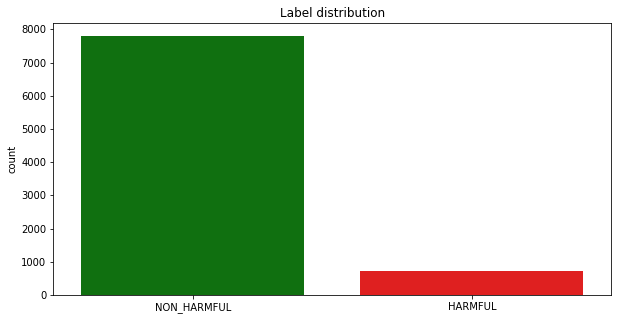

In [32]:
display_label_distribution(y_train)

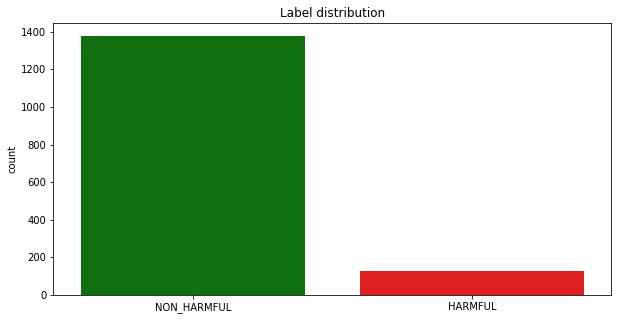

In [33]:
display_label_distribution(y_val)

In [34]:
oversampler = RandomOverSampler(sampling_strategy=0.7)
undersampler = RandomUnderSampler(sampling_strategy='majority')

In [35]:
X_train_over, y_train_over = oversampler.fit_resample(X_train_prepared, y_train)

In [36]:
np.unique(y_train_over, return_counts=True)

(array([0, 1]), array([7799, 5459]))

In [37]:
X_train_over, y_train_over = undersampler.fit_resample(X_train_over, y_train_over)

In [38]:
np.unique(y_train_over, return_counts=True)

(array([0, 1]), array([5459, 5459]))

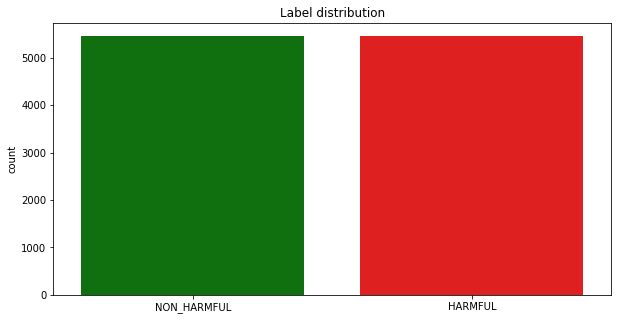

In [39]:
display_label_distribution(y_train_over)

In [456]:
# X_val_over, y_val_over = oversampler.fit_resample(X_val_prepared, y_val)

## Training

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [40]:
model_nb = BernoulliNB()

In [64]:
cross_val_score(model_nb, X_train_over, y_train_over, cv=4)

array([0.57326007, 0.56813187, 0.55331623, 0.55368267])

In [65]:
model_nb.fit(X_train_over, y_train_over)

BernoulliNB()

In [66]:
y_pred = model_nb.predict(X_val_prepared)

In [67]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.53      0.67      1377
           1       0.10      0.54      0.16       127

    accuracy                           0.53      1504
   macro avg       0.51      0.54      0.42      1504
weighted avg       0.86      0.53      0.63      1504



In [68]:
cm = confusion_matrix(y_val, y_pred)
cm

array([[726, 651],
       [ 58,  69]])

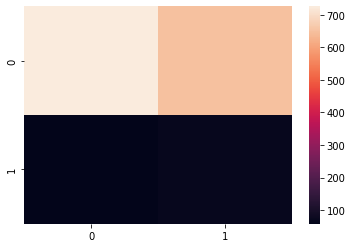

In [69]:
sns.heatmap(cm)
plt.show()

### Linear SVC

In [70]:
from sklearn.svm import LinearSVC

In [71]:
model_svc = LinearSVC()

In [72]:
cross_val_score(model_svc, X_train_over, y_train_over, cv=4)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


array([0.53113553, 0.55018315, 0.52876512, 0.51923782])

In [73]:
model_svc.fit(X_train_over, y_train_over)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC()

In [74]:
y_pred = model_svc.predict(X_val_prepared)

In [75]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.65      0.77      1377
           1       0.10      0.43      0.16       127

    accuracy                           0.63      1504
   macro avg       0.51      0.54      0.46      1504
weighted avg       0.86      0.63      0.71      1504



In [77]:
cm = confusion_matrix(y_val, y_pred)
cm

array([[899, 478],
       [ 73,  54]])

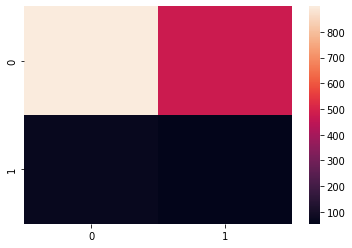

In [78]:
sns.heatmap(cm)
plt.show()

### Custom model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers.embeddings import Embedding

In [161]:
model = Sequential()
model.add(Embedding(NUM_WORDS, 32, input_length=MAX_TWEET_LENGTH))
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 280, 32)           96000     
                                                                 
 flatten_2 (Flatten)         (None, 8960)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                286752    
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 382,785
Trainable params: 382,785
Non-trainable params: 0
_________________________________________________________________


In [162]:
history = model.fit(X_train_over, y_train_over, validation_data=(X_val_prepared, y_val), epochs=3, batch_size=32, shuffle=True)

Epoch 1/3
342/342 [==============================] - 3s 5ms/step - loss: 0.6705 - accuracy: 0.6232 - val_loss: 0.4729 - val_accuracy: 0.8876
Epoch 2/3
342/342 [==============================] - 2s 5ms/step - loss: 0.4842 - accuracy: 0.8020 - val_loss: 0.4163 - val_accuracy: 0.8783
Epoch 3/3
342/342 [==============================] - 2s 4ms/step - loss: 0.3784 - accuracy: 0.8648 - val_loss: 0.3562 - val_accuracy: 0.8923


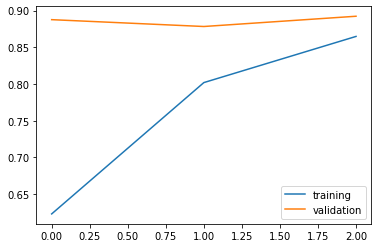

In [163]:
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()

In [164]:
scores = model.evaluate(X_val_prepared, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 89.23%


In [165]:
y_pred = model.predict(X_val_prepared)

In [166]:
y_pred

array([[0.10994404],
       [0.4449998 ],
       [0.4752357 ],
       ...,
       [0.01220053],
       [0.03723582],
       [0.22316186]], dtype=float32)

### Evaluation

In [167]:
from sklearn.metrics import precision_recall_curve

In [168]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)

In [169]:
def plot_precision_recall_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])
    plt.grid()

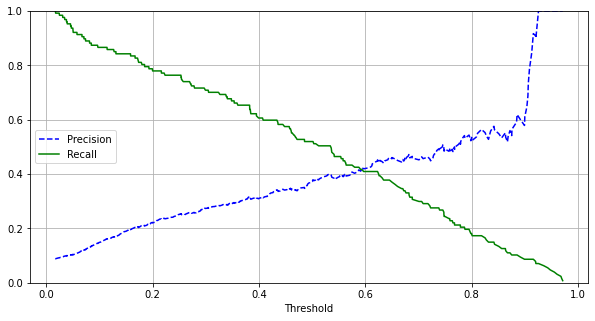

In [141]:
plot_precision_recall_threshold(precisions, recalls, thresholds)

In [142]:
decision_threshold = 0.60

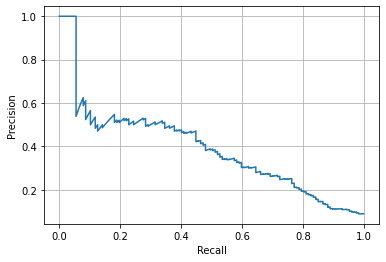

In [170]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

In [144]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [145]:
def plot_roc_curve(fpr, tpr, thresholds, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')

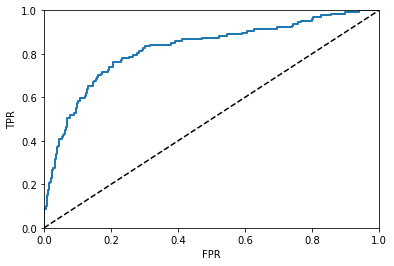

In [146]:
plot_roc_curve(fpr, tpr, thresholds)


In [171]:
from sklearn.metrics import roc_auc_score

In [172]:
roc_auc_score(y_val, y_pred)

0.8188233006821859

In [147]:
print(classification_report(y_val, y_pred > decision_threshold))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1377
           1       0.42      0.41      0.42       127

    accuracy                           0.90      1504
   macro avg       0.68      0.68      0.68      1504
weighted avg       0.90      0.90      0.90      1504



In [148]:
cm = confusion_matrix(y_val, y_pred > decision_threshold)
cm

array([[1306,   71],
       [  75,   52]])

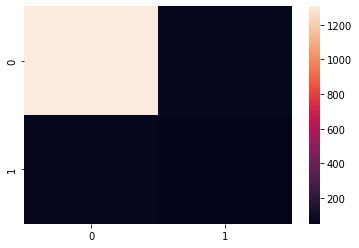

In [149]:
sns.heatmap(cm)
plt.show()

### Test set

In [150]:
os.listdir(TEST_DATA_DIR)

['test_set_clean_only_text.txt',
 'test_set_clean_only_tags.txt',
 'evaulate1.pl']

In [151]:
TEST_DATA = os.path.join(TEST_DATA_DIR, os.listdir(TEST_DATA_DIR)[0])
TEST_LABELS = os.path.join(TEST_DATA_DIR, os.listdir(TEST_DATA_DIR)[1])

In [152]:
test_data_df = pd.read_csv(TEST_DATA, sep='\n', names=['text'])
test_labels_df = pd.read_csv(TEST_LABELS, sep='\n', names=['label'])
test_data_df.shape, test_labels_df.shape

((1000, 1), (1000, 1))

In [153]:
test_df = pd.concat([test_data_df, test_labels_df], axis=1)
test_df.head()

,text,label
0,"@anonymized_account Spoko, jak im Duda z Moraw...",0
1,@anonymized_account @anonymized_account Ale on...,0
2,@anonymized_account No czy Prezes nie miał rac...,0
3,@anonymized_account @anonymized_account Przeci...,0
4,@anonymized_account @anonymized_account Owszem...,0


In [154]:
X_test, y_test = test_df['text'].values, test_df['label'].values
X_test.shape, y_test.shape

((1000,), (1000,))

In [155]:
X_test_prepared = pipeline.transform(X_test)

lower
newline
url
numbers
emoji
ascii
punctuations
lemma
tokenizer
padding


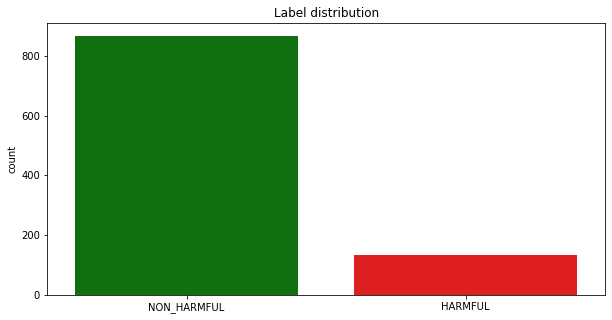

In [156]:
display_label_distribution(y_test)

In [157]:
y_pred = model.predict(X_test_prepared)

In [158]:
print(classification_report(y_test, y_pred > decision_threshold))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       866
           1       0.52      0.32      0.40       134

    accuracy                           0.87      1000
   macro avg       0.71      0.64      0.66      1000
weighted avg       0.85      0.87      0.86      1000



In [159]:
cm = confusion_matrix(y_test, y_pred > decision_threshold)
cm

array([[826,  40],
       [ 91,  43]])

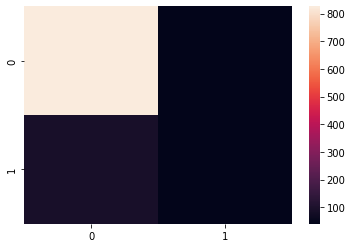

In [160]:
sns.heatmap(cm)
plt.show()

### Custom model LSTM

In [120]:
model = Sequential()
model.add(Embedding(NUM_WORDS, 32, input_length=MAX_TWEET_LENGTH))
# model.add(LSTM(128, recurrent_dropout=0.5, dropout=0.5))
model.add(LSTM(128))
# model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Dropout?
model.add(Dropout(0.5))
# model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))  # Regularization

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 280, 32)           96000     
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 211,713
Trainable params: 211,713
Non-trainable params: 0
_________________________________________________________________


In [123]:
history = model.fit(X_train_over, y_train_over, validation_data=(X_val_prepared, y_val), epochs=3, batch_size=32, shuffle=True)

Epoch 1/3
342/342 [==============================] - 16s 27ms/step - loss: 0.8759 - accuracy: 0.5024 - val_loss: 0.6831 - val_accuracy: 0.9156
Epoch 2/3
342/342 [==============================] - 8s 23ms/step - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6949 - val_accuracy: 0.0844
Epoch 3/3
342/342 [==============================] - 6s 17ms/step - loss: 0.6933 - accuracy: 0.4938 - val_loss: 0.6959 - val_accuracy: 0.0844


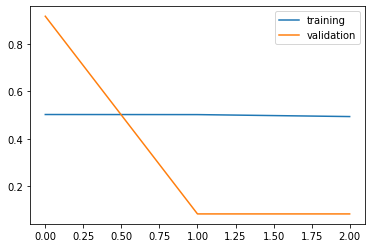

In [124]:
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()

In [125]:
scores = model.evaluate(X_val_prepared, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 8.44%


In [127]:
y_pred = model.predict(X_val_prepared)

### Confusion matrix

In [ ]:
print(classification_report(y_val_over, y_pred > 0.3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1377
           1       0.41      1.00      0.58       963

    accuracy                           0.41      2340
   macro avg       0.21      0.50      0.29      2340
weighted avg       0.17      0.41      0.24      2340



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Custom model 2

In [ ]:
# batch_size = 32
# nb_epoch = 12

# embedding_layer = Embedding(embedding_matrix.shape[0],
#                             embedding_matrix.shape[1],
#                             weights=[embedding_matrix],
#                             trainable=False)

# model = Sequential()
# model.add(embedding_layer)
# model.add(LSTM(128, recurrent_dropout=0.5, dropout=0.5))
# model.add(Dense(nb_classes))
# model.add(Activation('softmax'))
# model.summary()

In [ ]:
rnn = model.fit(X_train, Y_train, nb_epoch= nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_val, y_val))

### Hyperparameter tuning